# IGA-03. Medical Appointments: The No-Show Problem

## Problem setup

An actual medical clinic in the USA has been facing financial losses for the third consecutive year. The problem is that patients are not showing up after getting the appointments in the first place. So, the clinic has been losing profits.
As one of the attempts to understand the situation, the authorities of the clinic decided to develop a model for predicting actual visits of patients based on their characteristics.

In this assignment you are asked to work with the **Decision Tree** and the **Random Forest** classifiers to try and develop such a model. You will also need to run a traditional cross-validation to check stability of the obtained results.

The dataset consists of **110 000+ records** on the patients of the clinic. Description of the variables is given in the  **medical_data.xlsx** file which contains the necessary information on the variables.

### Students Daria Dobrego, Sergey Bruchkus, Giulio Bassan, Kien Do Trung

In [163]:
%matplotlib inline

# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.metrics import f1_score #for validation
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [115]:
# function to plot all features
def features_plots(discrete_vars):
    plt.figure(figsize=(15,24.5))
    
    # for continuous variables
    for i, cv in enumerate(['Age']):
        plt.subplot(7, 2, i+1)
        plt.hist(data[cv], bins=len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')
    
    # for discrete variables
    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+2)
        data[dv].value_counts().plot(kind='bar', title=dv)
        plt.ylabel('Frequency')

In [116]:
# function to estimate model performance

def model_performance(model_name, X_tr, y_tr, y_te, y_pred):
    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_te, y_pred))
    print('Test precision 0: %f'%metrics.precision_score(y_te, y_pred, pos_label=0))   
    print('Test precision 1: %f'%metrics.precision_score(y_te, y_pred, pos_label=1)) 
    print('Test recall 0: %f'%metrics.recall_score(y_te, y_pred, pos_label=0))   
    print('Test recall 1: %f'%metrics.recall_score(y_te, y_pred, pos_label=1))


## Task 0. Pre-processing the original data

**Study the steps taken here to pre-process the original data**.

In [117]:
# import the data 
data = pd.read_excel('medical_data.xlsx', sheet_name="data")

In [118]:
# look at the data
print(data.shape)
data.head(3)

(110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Status
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [119]:
# print of the frequency of unique values of each feature
for column in list(data.columns):
    print("{0:25} {1}".format(column, data[column].nunique()))

PatientId                 62299
AppointmentID             110527
Gender                    2
ScheduledDay              103549
AppointmentDay            27
Age                       104
Neighbourhood             81
Scholarship               2
Hipertension              2
Diabetes                  2
Alcoholism                2
Handicap                  5
SMS_received              2
Status                    2


In [120]:
# make summary statistics
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


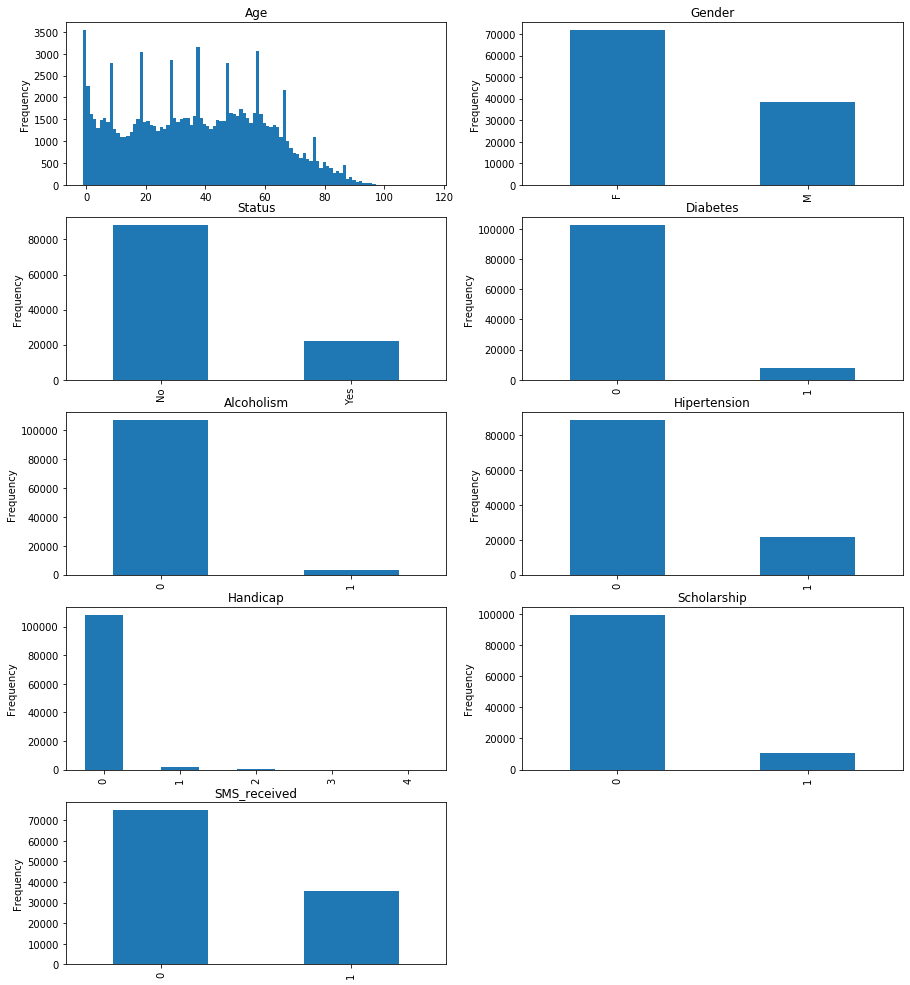

In [121]:
# make a list of discrete variables
discrete_vars = ['Gender', 'Status', 'Diabetes', 'Alcoholism', 'Hipertension', 'Handicap', 'Scholarship', 'SMS_received']

# construct graphs for features
features_plots(discrete_vars)


In [122]:
# remove unnecessary features
remove_vars=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood']
data.drop(remove_vars, inplace=True, axis=1)


In [123]:
# recode nominal variables
for field in ['Gender', 'Status']:
    data[field] = pd.Categorical(data[field]).codes

## Task 1 (1 point)

*1.The minimum age is -1, which is impossible.*
*2. 'Handicap' variable is binary, but the maximum for it is 4. It is wrong.* 

- Transform the dataset appropriately.

The same patients are mentioned for several times, since these clients have several appointments. It leads to peaks in 'age vs frequencies' graph. 
- Reconstruct the graphs of the discrete features.

In [130]:
# introduce transformations of the dataset here
data = data.drop(data[data.Age < 0].index) #excluding '-1' age
data['Handicap'].replace(2, 1, inplace=True)
data['Handicap'].replace(4, 1, inplace=True)
data['Handicap'].replace(3, 1, inplace=True) #replace 2,3,4 values in Handicap with 1. (binary variable)
data.describe() 

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Status
count,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,0.350026,37.089219,0.098266,0.197248,0.071865,0.030400,0.020276,0.321029,0.201934
std,0.476980,23.110026,0.297676,0.397923,0.258266,0.171686,0.140943,0.466874,0.401445
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


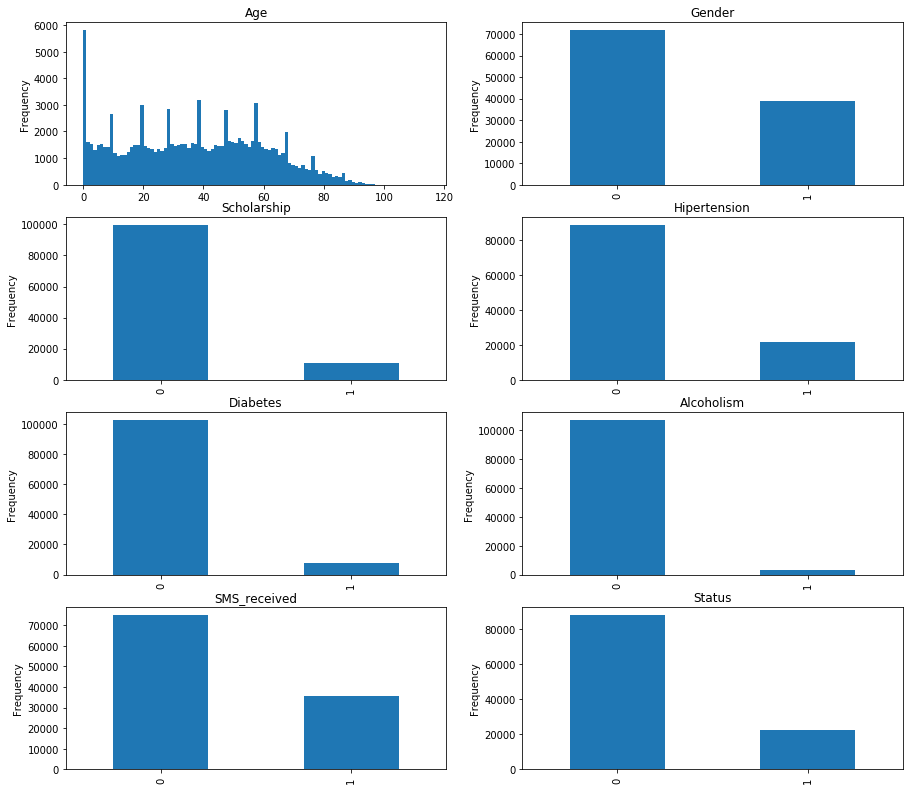

In [131]:
# check the results
discrete_vars2 = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'Status']

# constructing graphs for features
features_plots(discrete_vars2)

### Preparing for calculations

In [132]:
# make X and y
y = data['Status']

X = data.copy()
X.drop(["Status"], axis=1, inplace=True)

In [133]:
# make a fixed split into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)

## Task 2 (1 point)

- Work with the obtained split on the training and the test samples, and estimate a **Decision Tree** classifier with the **default parameters**.
- Estimate its performance using the model_performance function.
- Briefly comment on the results.

In [150]:
# define the DT-classifier
clfr_DT = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=0)

# estimate the DT-model

clfr_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [171]:
# check performance of the DT-model
y_pred = clfr_DT.predict(X_test)

print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
print(metrics.classification_report(y_true=y_test, y_pred=y_pred))

[[17535   119]
 [ 4388    64]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17654
           1       0.35      0.01      0.03      4452

    accuracy                           0.80     22106
   macro avg       0.57      0.50      0.46     22106
weighted avg       0.71      0.80      0.71     22106



In [172]:
model_performance(clfr_DT,X_train,y_train,y_test,y_pred)

Model name: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Test accuracy (Accuracy Score): 0.796119
Test precision 0: 0.799845
Test precision 1: 0.349727
Test recall 0: 0.993259
Test recall 1: 0.014376


**Give your comments here**
We have high recall for 0 class. Recall for the 1 class is very low. Overall accuracy is 0,79 which is relatively low. We also notice class imbalance problem (17535 against 64).

## Task 3 (1 point)

- Work with the obtained split on the training and the test samples, and estimate a **Random Forest** classifier for 200 trees.
- Estimate its performance using the **model_performance** function.
- Compare the results of performance of the RF-model with the DT-model. Briefly comment.

In [173]:
# define the RF-classifier
clfr_RF = RandomForestClassifier(n_estimators=200)



clfr_RF.fit(X_train, y_train)
y_predict_RF = clfr_RF.predict(X_test)

In [174]:
# check performance of the RF-model
y_predict_RF = clfr_RF.predict(X_test)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_predict_RF))
print(metrics.classification_report(y_true=y_test, y_pred=y_predict_RF))
# estimate the RF-model
model_performance(clfr_RF,X_train,y_train,y_test,y_predict_RF)

[[17515   139]
 [ 4374    78]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17654
           1       0.36      0.02      0.03      4452

    accuracy                           0.80     22106
   macro avg       0.58      0.50      0.46     22106
weighted avg       0.71      0.80      0.71     22106

Model name: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Test accuracy (Accuracy Score): 0.795847
Test precision 0: 0.800174
Test precision 1: 0.359447
Test recall 0: 0.992126
Test recall 1: 0.017

In [180]:
#Compare the results of performance of the RF-model with the DT-model. Briefly comment.
#Both models have pretty much the same results, the RF model has better recall for 1 class.

## Task 4 (1 point)

- Using the **cross_validate** function, run a 10-fold cross-validation for the Decision Tree classifier for the **F1** metric.
- Print out the results of the cross-validation.


In [182]:
from sklearn.model_selection import cross_validate
crossv = cross_validate(lasso, X, y, cv=3)

In [176]:
# F1: results for DT
f1 = f1_score(y_test,y_pred)
f1

0.027615965480043154

## Task 5 (1 point)

- Comment on the obtained performance results of the both classifiers. Specify **any two** peculiarities.

1) Both models show relatively high performance for the recalls for class 0, because the majority of clients tend not to show up. So, its easier for the classifier to predict the majority class.
2) On the other hand, the recall for the minority class is actually tiny: less than 1%


- What would you suggest to do to improve performance of the classifiers? Give **one specific** suggestion.

The potential reason for both problems lies in balancing the sample (with upsampling of people who shaw up through creating "synthetic patients"